In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

def read_dataset(template, start_idx, end_idx):
    frames = [ pd.read_json(f) for f in [template.format(i) for i in range(start_idx, end_idx+1)] ]
    return pd.concat(frames, ignore_index = True)

dftrain = read_dataset("datasets/dataset_initial/dataset_{:02}.json", 0, 13)
y_train = dftrain.pop('round_winner').map(lambda s: 0 if s == "CT" else 1)

dfeval = read_dataset("datasets/dataset_initial/dataset_{:02}.json", 13, 17)
y_eval = dfeval.pop('round_winner').map(lambda s: 0 if s == "CT" else 1)
print(dftrain.head())

        map current_score round_status  round_status_time_left  \
0  de_dust2        [0, 0]   FreezeTime                20.00000   
1  de_dust2        [0, 0]   FreezeTime                 1.03125   
2  de_dust2        [0, 0]       Normal                96.03125   
3  de_dust2        [0, 0]       Normal                76.03125   
4  de_dust2        [0, 1]   FreezeTime                19.96875   

                                       alive_players active_smokes  \
0  [{'health': 100, 'armor': 0, 'has_helmet': Fal...            []   
1  [{'health': 100, 'armor': 100, 'has_helmet': F...            []   
2  [{'health': 100, 'armor': 100, 'has_helmet': F...            []   
3  [{'health': 100, 'armor': 100, 'has_helmet': F...            []   
4  [{'health': 100, 'armor': 100, 'has_helmet': F...            []   

  active_molotovs                                     previous_kills  \
0              []                                                 []   
1              []                     

In [2]:
CATEGORICAL_COLUMNS = ['round_status', 'map']
NUMERIC_COLUMNS = ['round_status_time_left']
INTEGER_COLUMNS = ['alive_players_t', 'alive_players_ct', "health_t", "health_ct", "money_ct", "money_t"]

def get_attr(ds, team, attr=None):
    team_players = map(lambda players: filter(lambda p: p["team"] == team, players), ds['alive_players'])
    if attr:
        team_players = map(lambda players: map(lambda p: p[attr], players), team_players)
    
    return list(map(lambda p: list(p), team_players))

for ds in [dftrain, dfeval]:
    ds['alive_players_t']  = list(map(len ,get_attr(ds, "Terrorist")))
    ds['alive_players_ct'] = list(map(len, get_attr(ds, "CT")))
    ds['health_ct']        = list(map(sum, get_attr(ds, "CT", "health")))
    ds['health_t']         = list(map(sum, get_attr(ds, "Terrorist", "health")))
    ds['money_ct']         = list(map(sum, get_attr(ds, "CT", "money")))
    ds['money_t']          = list(map(sum, get_attr(ds, "Terrorist", "money")))

print(dftrain.info())

feature_columns = []
feature_names = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS + INTEGER_COLUMNS
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))

for feature_name in INTEGER_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.int32))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71522 entries, 0 to 71521
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   map                     71522 non-null  object 
 1   current_score           71522 non-null  object 
 2   round_status            71522 non-null  object 
 3   round_status_time_left  71522 non-null  float64
 4   alive_players           71522 non-null  object 
 5   active_smokes           71522 non-null  object 
 6   active_molotovs         71522 non-null  object 
 7   previous_kills          71522 non-null  object 
 8   planted_bomb            42731 non-null  object 
 9   alive_players_t         71522 non-null  int64  
 10  alive_players_ct        71522 non-null  int64  
 11  health_ct               71522 non-null  int64  
 12  health_t                71522 non-null  int64  
 13  money_ct                71522 non-null  int64  
 14  money_t                 71522 non-null

In [3]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df.filter(items=feature_names)), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function
        
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [4]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()

In [5]:
print(result)

{'accuracy': 0.6220279, 'accuracy_baseline': 0.5140156, 'auc': 0.6920899, 'auc_precision_recall': 0.7150987, 'average_loss': 1.3208537, 'label/mean': 0.5140156, 'loss': 1.3205788, 'precision': 0.6782264, 'prediction/mean': 0.40757233, 'recall': 0.50358653, 'global_step': 22360}


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /run/user/1000/tmp_8fw0a0u/model.ckpt-22360
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


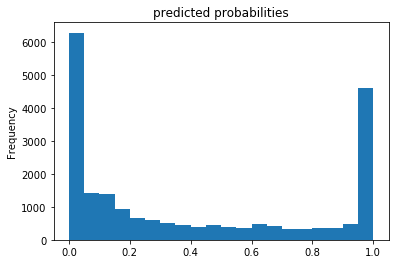

In [6]:
tf.keras.backend.set_floatx('float64')
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [7]:
tf.get_logger().setLevel('WARN')

def predict_idx(data_df, idx):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices(dict(data_df.filter(items=feature_names)))
        ds = ds.skip(idx).take(1).batch(1)
        return ds
    return input_function

def predict_index(ds, idx):
    for feature in feature_names:
        print(feature, ds[feature][idx])
        
    print("")
    
    for pred in linear_est.predict(predict_idx(ds, idx)):
        probs = pred['probabilities']
        print("Win probability: CT: {:.2} T: {:.2}".format(probs[0], probs[1]))

    print("")

wt_names = linear_est.get_variable_names()
for name in wt_names:
    if name.endswith("weights"):
        val = linear_est.get_variable_value(name)
        print(name, val)

print(feature_columns)

for i in range(100,120):
    predict_index(dfeval, i)

linear/linear_model/alive_players_ct/weights [[-0.2753162]]
linear/linear_model/alive_players_t/weights [[0.8566536]]
linear/linear_model/bias_weights [1.0819103]
linear/linear_model/health_ct/weights [[-0.08782861]]
linear/linear_model/health_t/weights [[0.08122013]]
linear/linear_model/map/weights [[ 1.7459878 ]
 [-0.06751216]
 [ 0.01124949]
 [ 2.4008303 ]
 [-0.01077917]
 [ 0.83870405]
 [-0.5570975 ]
 [-1.8639314 ]]
linear/linear_model/money_ct/weights [[0.00012078]]
linear/linear_model/money_t/weights [[-0.00013922]]
linear/linear_model/round_status/weights [[-1.8761853 ]
 [ 0.81592077]
 [ 8.533228  ]]
linear/linear_model/round_status_time_left/weights [[-0.0292008]]
[VocabularyListCategoricalColumn(key='round_status', vocabulary_list=('FreezeTime', 'Normal', 'BombPlanted'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='map', vocabulary_list=('de_dust2', 'de_nuke', 'de_mirage', 'de_inferno', 'de_overpass', 'de_vertigo', 'de_train', 'de_c